## Finding Arduino Ports
When working with Arduino, it's essential to know which port your Arduino board is connected to on your computer. This is necessary for uploading code and communicating with the board. Each port is identified by a unique name or number, depending on the operating system:

- On Windows, ports are named like `COM3`, `COM4`, etc.
- On macOS and Linux, ports are named like `/dev/ttyUSB0`, `/dev/ttyACM0`, etc.

Run the next cell to know the port number.


In [4]:
import serial.tools.list_ports

def list_all_ports():
    ports = serial.tools.list_ports.comports()

    if not ports:
        print("No serial ports found.")
    else:
        print("Available serial ports:")
        for port in ports:
            print(f"Port: {port.device}, Description: {port.description}")

list_all_ports()

Available serial ports:
Port: COM15, Description: Standard Serial over Bluetooth link (COM15)
Port: COM31, Description: USB Serial Device (COM31)
Port: COM16, Description: Standard Serial over Bluetooth link (COM16)


#### Setup the serial communication with arduino

Change the port value in the next cell with the result that you got in the previous cell

In [5]:
import serial
import time

port = 'COM31' 

ser = serial.Serial(port, 115200)

time.sleep(2)

## Command to pass the read the Transistor data
- Use `m2tran_vds` to step Vgs and sweep vds
- Use `m2tran_vgs` to step Vds and sweep vgs

Note: To read data from 'csv' file rather from real hardware change the `read_data_from_csv` variable to value `1`.

Below shown is the transistor data measurement setup:
![diode data measurement setup](transistor_image.jpg)

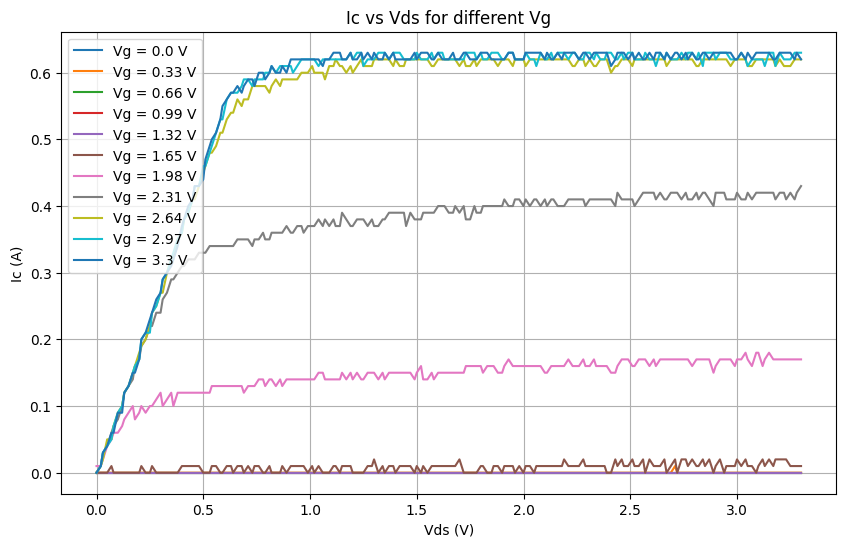

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import csv

read_data_from_csv = 1

# Initialize lists to store the data
gate_voltage = []
drain_voltage = []
channel_current = []

if read_data_from_csv == 0:
    print("Type your command:")
    command = input("> ").strip()
    ser.write((command + '\n').encode())
    
    if command == 'm2tran_vds':
        # Read data from the serial port until "Ready to enter next command" is found
        gate_voltage = []
        drain_voltage = []
        channel_current = []
        print("Reading data ...", end= "")
        while True:
            print(".", end = "")
            line = ser.readline().decode().strip()
            if "Ready to enter next command" in line:
                break
            # Assuming data is in the format: "Vg,Vds,Ic"
            values = list(line.split(','))
            if len(values) == 3:
                gate_voltage.append(float(values[0]))
                drain_voltage.append(float(values[1]))
                channel_current.append(float(values[2]))
        
        
        # Convert to numpy arrays for easier slicing
        gate_voltage = np.array(gate_voltage)
        drain_voltage = np.array(drain_voltage)
        channel_current = np.array(channel_current)
        
        # Find unique gate voltages
        unique_vg = np.unique(gate_voltage)
        
        # Number of samples for each Vg sweep (e.g., 200)
        num_samples = len(drain_voltage) // len(unique_vg)
        
        # Plot Ic vs Vds for each unique Vg
        plt.figure(figsize=(10, 6))
        
        for vg in unique_vg:
            # Select the corresponding data for this Vg
            mask = gate_voltage == vg
            vds_sweep = drain_voltage[mask]
            ic_sweep = channel_current[mask]
            
            # Plot Vds vs Ic for this Vg
            plt.plot(vds_sweep, ic_sweep, label=f'Vgs = {vg} V')
        
        plt.xlabel('Vds (V)')
        plt.ylabel('Ids (A)')
        plt.title('Ids vs Vds for different Vg')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    if command == 'm2tran_vgs':
        # Read data from the serial port until "Ready to enter next command" is found
        gate_voltage = []
        drain_voltage = []
        channel_current = []
        print("Reading data ...", end= "")
        while True:
            print(".", end = "")
            line = ser.readline().decode().strip()
            if "Ready to enter next command" in line:
                break
            # Assuming data is in the format: "Vg,Vds,Ic"
            values = list(line.split(','))
            if len(values) == 3:
                drain_voltage.append(float(values[0]))
                gate_voltage.append(float(values[1]))
                channel_current.append(float(values[2]))
        
        
        # Convert to numpy arrays for easier slicing
        gate_voltage = np.array(gate_voltage)
        drain_voltage = np.array(drain_voltage)
        channel_current = np.array(channel_current)
        
        # Find unique gate voltages
        unique_vd = np.unique(drain_voltage)
        
        # Number of samples for each Vg sweep (e.g., 200)
        num_samples = len(gate_voltage) // len(unique_vd)
        
        # Plot Ic vs Vds for each unique Vg
        plt.figure(figsize=(10, 6))
        
        # for vd in unique_vd:
        #     # Select the corresponding data for this Vg
        #     mask = drain_voltage == vd
        #     vgs_sweep = gate_voltage[mask]
        #     ic_sweep = channel_current[mask]
            
        #     # Plot Vds vs Ic for this Vg
        #     plt.plot(vgs_sweep, ic_sweep, label=f'Vd = {vd} V')

        for vd in unique_vd:
            # Select the corresponding data for this Vd
            mask = drain_voltage == vd
            vgs_sweep = gate_voltage[mask]
            ic_sweep = channel_current[mask]
        
            # Filter the data to include only Vgs values less than or equal to 2.2V
            valid_mask = vgs_sweep <= 2.3
            vgs_sweep = vgs_sweep[valid_mask]
            ic_sweep = ic_sweep[valid_mask]
        
            # Plot Vgs vs Ic for this Vd
            plt.plot(vgs_sweep, ic_sweep, label=f'Vds = {vd} V')
        
        plt.xlabel('Vgs (V)')
        plt.ylabel('Ids (A)')
        plt.title('Ids vs Vgs for different Vd')
        plt.legend()
        plt.grid(True)
        plt.show()

else: 
    with open('nmos_data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            gate_voltage.append(float(row[0])) 
            drain_voltage.append(float(row[1]))
            channel_current.append(float(row[2]))
            
    # Convert to numpy arrays for easier slicing
    gate_voltage = np.array(gate_voltage)
    drain_voltage = np.array(drain_voltage)
    channel_current = np.array(channel_current)
    
    # Find unique gate voltages
    unique_vg = np.unique(gate_voltage)
    
    # Number of samples for each Vg sweep (e.g., 200)
    num_samples = len(drain_voltage) // len(unique_vg)
    
    # Plot Ic vs Vds for each unique Vg
    plt.figure(figsize=(10, 6))
    
    for vg in unique_vg:
        # Select the corresponding data for this Vg
        mask = gate_voltage == vg
        vds_sweep = drain_voltage[mask]
        ic_sweep = channel_current[mask]
        
        # Plot Vds vs Ic for this Vg
        plt.plot(vds_sweep, ic_sweep, label=f'Vgs = {vg} V')
    
    plt.xlabel('Vds (V)')
    plt.ylabel('Ids (A)')
    plt.title('Ids vs Vds for different Vg')
    plt.legend()
    plt.grid(True)
    plt.show()
    

## Curve Fitting
Note: Before running the next cell make sure that scipy is installed. Following is the command to do: `pip install scipy`

Fitted Parameters: k = 1.13216e+00, Vt = 2.25 V


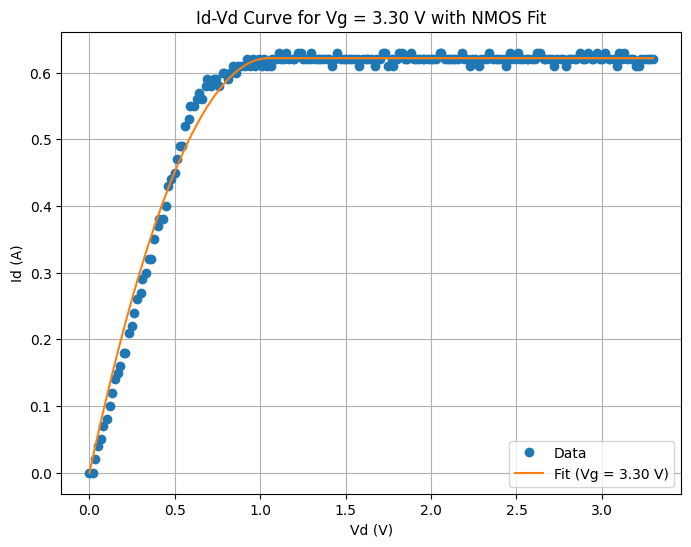

In [42]:
from scipy.optimize import curve_fit

# Function for the triode region (when Vd < Vg - Vt)
def triode(Vd, k, Vt, Vg):
    return k * ((Vg - Vt) * Vd - 0.5 * Vd**2)

# Function for the saturation region (when Vd >= Vg - Vt)
def saturation(Vd, k, Vt, Vg):
    return 0.5 * k * (Vg - Vt)**2 * np.ones_like(Vd)

# Combined NMOS model function
def nmos_model(Vd, k, Vt, Vg):
    Vdsat = Vg - Vt
    Id = np.where(Vd < Vdsat, triode(Vd, k, Vt, Vg), saturation(Vd, k, Vt, Vg))
    return Id

if command == 'm2tran_vds':    
    vg_last = unique_vg[-1]
    mask = gate_voltage == vg_last
    # Vd and Id data for the last block
    Vd_data = drain_voltage[mask]
    Id_data = channel_current[mask]
    
    # Initial guess for fitting parameters: k, Vt
    initial_guess = [1e-5, 0.5]  # Adjust these values based on your dataset
    
    # Perform the curve fitting
    popt, pcov = curve_fit(lambda Vd, k, Vt: nmos_model(Vd, k, Vt, vg_last), Vd_data, Id_data, p0=initial_guess)
    
    # Extract the fitting parameters
    k_fit, Vt_fit = popt
    
    # Print the fitting parameters
    print(f"Fitted Parameters: k = {k_fit:.5e}, Vt = {Vt_fit:.2f} V")
    
    # Generate a smooth range of Vd values for the fitted curve
    Vd_fit = np.linspace(min(Vd_data), max(Vd_data), 1000)
    
    # Generate the fitted Id values using the NMOS model
    Id_fit = nmos_model(Vd_fit, k_fit, Vt_fit, vg_last)
    
    # Plot the original data and the fitted curve
    plt.figure(figsize=(8, 6))
    plt.plot(Vd_data, Id_data, 'o', label='Data')  # Original data points
    plt.plot(Vd_fit, Id_fit, '-', label=f'Fit (Vg = {vg_last:.2f} V)')  # Fitted curve
    plt.title(f'Id-Vd Curve for Vg = {vg_last:.2f} V with NMOS Fit')
    plt.xlabel('Vd (V)')
    plt.ylabel('Id (A)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Mosfet Curve Fitting

Make sure to read data from 'csv' file rather from real hardware. Change the read_data_from_csv variable to value 1. 

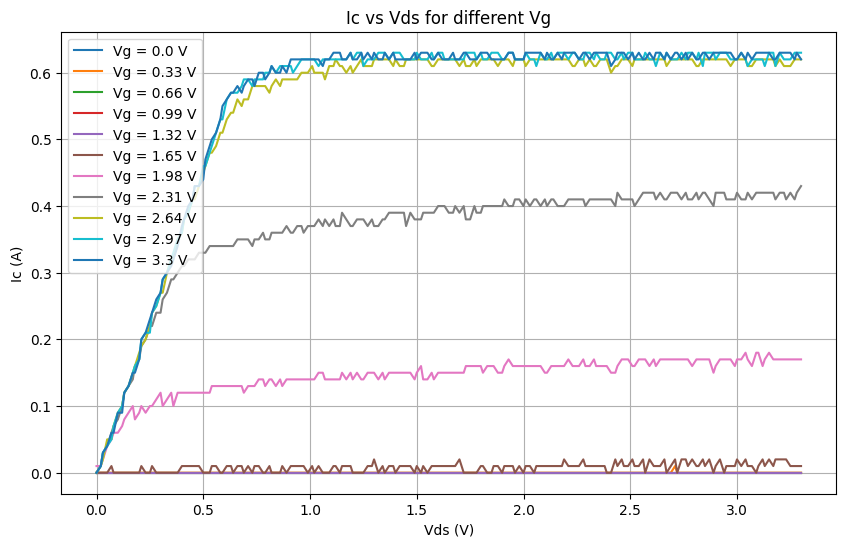

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import csv

read_data_from_csv = 1

# Initialize lists to store the data
gate_voltage = []
drain_voltage = []
channel_current = []

if read_data_from_csv == 0:
    print("Type your command:")
    command = input("> ").strip()
    ser.write((command + '\n').encode())
    
    if command == 'm2tran_vds':
        # Read data from the serial port until "Ready to enter next command" is found
        gate_voltage = []
        drain_voltage = []
        channel_current = []
        print("Reading data ...", end= "")
        while True:
            print(".", end = "")
            line = ser.readline().decode().strip()
            if "Ready to enter next command" in line:
                break
            # Assuming data is in the format: "Vg,Vds,Ic"
            values = list(line.split(','))
            if len(values) == 3:
                gate_voltage.append(float(values[0]))
                drain_voltage.append(float(values[1]))
                channel_current.append(float(values[2]))
        
        
        # Convert to numpy arrays for easier slicing
        gate_voltage = np.array(gate_voltage)
        drain_voltage = np.array(drain_voltage)
        channel_current = np.array(channel_current)
        
        # Find unique gate voltages
        unique_vg = np.unique(gate_voltage)
        
        # Number of samples for each Vg sweep (e.g., 200)
        num_samples = len(drain_voltage) // len(unique_vg)
        
        # Plot Ic vs Vds for each unique Vg
        plt.figure(figsize=(10, 6))
        
        for vg in unique_vg:
            # Select the corresponding data for this Vg
            mask = gate_voltage == vg
            vds_sweep = drain_voltage[mask]
            ic_sweep = channel_current[mask]
            
            # Plot Vds vs Ic for this Vg
            plt.plot(vds_sweep, ic_sweep, label=f'Vg = {vg} V')
        
        plt.xlabel('Vds (V)')
        plt.ylabel('Ic (A)')
        plt.title('Ic vs Vds for different Vg')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    if command == 'm2tran_vgs':
        # Read data from the serial port until "Ready to enter next command" is found
        gate_voltage = []
        drain_voltage = []
        channel_current = []
        print("Reading data ...", end= "")
        while True:
            print(".", end = "")
            line = ser.readline().decode().strip()
            if "Ready to enter next command" in line:
                break
            # Assuming data is in the format: "Vg,Vds,Ic"
            values = list(line.split(','))
            if len(values) == 3:
                drain_voltage.append(float(values[0]))
                gate_voltage.append(float(values[1]))
                channel_current.append(float(values[2]))
        
        
        # Convert to numpy arrays for easier slicing
        gate_voltage = np.array(gate_voltage)
        drain_voltage = np.array(drain_voltage)
        channel_current = np.array(channel_current)
        
        # Find unique gate voltages
        unique_vd = np.unique(drain_voltage)
        
        # Number of samples for each Vg sweep (e.g., 200)
        num_samples = len(gate_voltage) // len(unique_vd)
        
        # Plot Ic vs Vds for each unique Vg
        plt.figure(figsize=(10, 6))
        
        for vd in unique_vd:
            # Select the corresponding data for this Vg
            mask = drain_voltage == vd
            vgs_sweep = gate_voltage[mask]
            ic_sweep = channel_current[mask]
            
            # Plot Vds vs Ic for this Vg
            plt.plot(vgs_sweep, ic_sweep, label=f'Vd = {vd} V')
        
        plt.xlabel('Vgs (V)')
        plt.ylabel('Ic (A)')
        plt.title('Ic vs Vgs for different Vd')
        plt.legend()
        plt.grid(True)
        plt.show()

else: 
    with open('nmos_data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            gate_voltage.append(float(row[0])) 
            drain_voltage.append(float(row[1]))
            channel_current.append(float(row[2]))
            
    # Convert to numpy arrays for easier slicing
    gate_voltage = np.array(gate_voltage)
    drain_voltage = np.array(drain_voltage)
    channel_current = np.array(channel_current)
    
    # Find unique gate voltages
    unique_vg = np.unique(gate_voltage)
    
    # Number of samples for each Vg sweep (e.g., 200)
    num_samples = len(drain_voltage) // len(unique_vg)
    
    # Plot Ic vs Vds for each unique Vg
    plt.figure(figsize=(10, 6))
    
    for vg in unique_vg:
        # Select the corresponding data for this Vg
        mask = gate_voltage == vg
        vds_sweep = drain_voltage[mask]
        ic_sweep = channel_current[mask]
        
        # Plot Vds vs Ic for this Vg
        plt.plot(vds_sweep, ic_sweep, label=f'Vg = {vg} V')
    
    plt.xlabel('Vds (V)')
    plt.ylabel('Ic (A)')
    plt.title('Ic vs Vds for different Vg')
    plt.legend()
    plt.grid(True)
    plt.show()
    

Iteration: k = 6.79501e-01, Vt = 1.92 V, RMSE = 3.79856e-02
Iteration: k = 6.73246e-01, Vt = 1.93 V, RMSE = 3.69720e-02
Iteration: k = 6.89987e-01, Vt = 1.94 V, RMSE = 3.54279e-02
Iteration: k = 7.71290e-01, Vt = 2.02 V, RMSE = 2.86486e-02
Iteration: k = 8.08298e-01, Vt = 2.05 V, RMSE = 2.63120e-02
Iteration: k = 8.67176e-01, Vt = 2.10 V, RMSE = 2.40832e-02
Iteration: k = 9.04280e-01, Vt = 2.13 V, RMSE = 2.14702e-02
Iteration: k = 9.85718e-01, Vt = 2.17 V, RMSE = 1.71764e-02
Iteration: k = 1.02979e+00, Vt = 2.20 V, RMSE = 1.56734e-02
Iteration: k = 1.06582e+00, Vt = 2.22 V, RMSE = 1.52467e-02
Iteration: k = 1.08336e+00, Vt = 2.23 V, RMSE = 1.49347e-02
Iteration: k = 1.10650e+00, Vt = 2.24 V, RMSE = 1.47046e-02
Iteration: k = 1.12190e+00, Vt = 2.24 V, RMSE = 1.46834e-02
Iteration: k = 1.12141e+00, Vt = 2.24 V, RMSE = 1.46786e-02
Iteration: k = 1.12179e+00, Vt = 2.24 V, RMSE = 1.46785e-02

Final fitted parameters: k = 1.12179e+00, Vt = 2.24 V


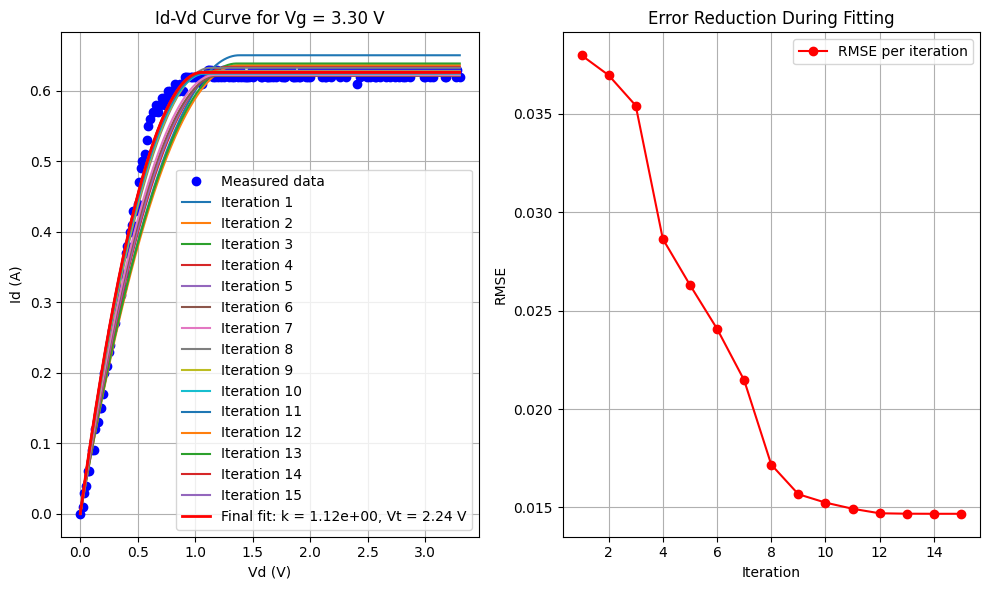

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import csv

# Function for the triode region (when Vd < Vg - Vt)
def triode(Vd, k, Vt, Vg):
    return k * ((Vg - Vt) * Vd - 0.5 * Vd**2)

# Function for the saturation region (when Vd >= Vg - Vt)
def saturation(Vd, k, Vt, Vg):
    return 0.5 * k * (Vg - Vt)**2 * np.ones_like(Vd)

# Combined NMOS model function
def nmos_model(Vd, k, Vt, Vg):
    Vdsat = Vg - Vt
    Id = np.where(Vd < Vdsat, triode(Vd, k, Vt, Vg), saturation(Vd, k, Vt, Vg))
    return Id

# Step 1: Define the cost function (RMSE)
def cost_function(params, Vd, Id, Vg_last):
    """
    RMSE between the measured data and the NMOS model.
    """
    k, Vt = params
    model_Id = nmos_model(Vd, k, Vt, Vg_last)
    error = np.sqrt(np.mean((Id - model_Id) ** 2))  # RMSE
    return error

# Step 2: Log the parameters and RMSE for each iteration
def callback(params, Vd_data, Id_data, Vg_last, params_log, error_log):
    current_rmse = cost_function(params, Vd_data, Id_data, Vg_last)
    params_log.append(params.copy())
    error_log.append(current_rmse)
    print(f"Iteration: k = {params[0]:.5e}, Vt = {params[1]:.2f} V, RMSE = {current_rmse:.5e}")

# Step 3: Perform iterative fitting and visualize the process
def iterative_fit_and_plot(Vd_data, Id_data, initial_guess, Vg_last):
    # Lists to capture the parameter evolution and error
    params_log = []
    error_log = []
    
    # Define a callback function that logs parameters and errors during optimization
    def optimization_callback(params):
        callback(params, Vd_data, Id_data, Vg_last, params_log, error_log)
    
    # Perform the optimization using 'minimize' with L-BFGS-B method
    result = minimize(
        cost_function, initial_guess, args=(Vd_data, Id_data, Vg_last),
        method='L-BFGS-B', bounds=[(0, 1e8), (0, 3)],  # k and Vt bounds
        callback=optimization_callback,
        options={'maxiter': 1000}
    )
    
    # Final parameters
    k_fit, Vt_fit = result.x
    print(f"\nFinal fitted parameters: k = {k_fit:.5e}, Vt = {Vt_fit:.2f} V")

    # Plotting
    Vd_fit = np.linspace(min(Vd_data), max(Vd_data), 1000)
    
    # Plot the measured data
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(Vd_data, Id_data, 'bo', label='Measured data')
    
    # Plot intermediate fits for each iteration
    for i, params in enumerate(params_log):
        k, Vt = params
        Id_fit = nmos_model(Vd_fit, k, Vt, Vg_last)
        plt.plot(Vd_fit, Id_fit, label=f'Iteration {i+1}')
    
    # Final fit
    Id_final_fit = nmos_model(Vd_fit, k_fit, Vt_fit, Vg_last)
    plt.plot(Vd_fit, Id_final_fit, 'r-', label=f'Final fit: k = {k_fit:.2e}, Vt = {Vt_fit:.2f} V', linewidth=2)
    
    # Add labels and grid for the fit plot
    plt.xlabel('Vd (V)')
    plt.ylabel('Id (A)')
    plt.title(f'Id-Vd Curve for Vg = {Vg_last:.2f} V')
    plt.legend()
    plt.grid(True)

    # Plot RMSE vs. Iteration
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(error_log) + 1), error_log, 'r-o', label='RMSE per iteration')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Error Reduction During Fitting')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Reading data from CSV and executing the fitting process
def load_data_and_fit():
    gate_voltage = []
    drain_voltage = []
    channel_current = []

    # Read data from CSV file
    with open('nmos_data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            gate_voltage.append(float(row[0]))
            drain_voltage.append(float(row[1]))
            channel_current.append(float(row[2]))

    # Convert to numpy arrays for easier slicing
    gate_voltage = np.array(gate_voltage)
    drain_voltage = np.array(drain_voltage)
    channel_current = np.array(channel_current)

    # Find unique gate voltages
    unique_vg = np.unique(gate_voltage)

    # Assuming we're interested in fitting the last Vg value (e.g., for 'm2tran_vds' command)
    vg_last = unique_vg[-1]
    
    # Extract the corresponding Vd and Id data for the last Vg
    mask = gate_voltage == vg_last
    Vd_data = drain_voltage[mask]
    Id_data = channel_current[mask]

    # Initial guess for fitting parameters
    initial_guess = [1e-1, 2]  # Initial guess for k and Vt

    # Perform iterative fitting and visualize the process
    iterative_fit_and_plot(Vd_data, Id_data, initial_guess, vg_last)

# Execute the process
load_data_and_fit()